In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('E:\\Python\\AML\\HW7\\train.csv')

In [4]:
# Уменьшим размер данных для ускорения обучения, возьмем случайную подвыборку 20% данных
from sklearn.model_selection import StratifiedShuffleSplit

random_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in random_splitter.split(data, data.target):
    data = data.iloc[test_index]

In [5]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=777)

for train_index, test_index in splitter.split(data, data.target):
    d_train = data.iloc[train_index]
    d_test = data.iloc[test_index]
    
    y_train = data['target'].iloc[train_index]
    y_test = data['target'].iloc[test_index]

In [6]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['ID', 'target'])]

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = d_train[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

v3         3
v22     6610
v24        5
v30        7
v31        3
v47        9
v52       12
v56       90
v66        3
v71        5
v74        3
v75        4
v79       17
v91        7
v107       7
v110       3
v112      22
v113      34
v125      88
dtype: int64


In [7]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat], columns=cat_feat)
dummy_test = pd.get_dummies(d_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train) & set(dummy_test))

dummy_train = dummy_train[dummy_cols]
dummy_test = dummy_test[dummy_cols]


# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X_train = pd.concat([d_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

 # Предсказываем цены на недвижимость. Строим случайный лес

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
reg_rf = RandomForestRegressor(n_estimators=10, max_depth=5, max_samples=10, max_features=0.5)
reg_rf.fit(X_train, y_train)  

RandomForestRegressor(max_depth=5, max_features=0.5, max_samples=10,
                      n_estimators=10)

In [10]:
imp = pd.Series(reg_rf.feature_importances_)
imp.sort_values(ascending=False)

23     0.100000
17     0.100000
19     0.066667
10     0.064286
67     0.064286
         ...   
141    0.000000
140    0.000000
139    0.000000
138    0.000000
109    0.000000
Length: 219, dtype: float64

# Стекинг

### Готовим признаки

In [11]:
from sklearn.preprocessing import StandardScaler

train_median = d_train[num_feat].median()

X_train = pd.concat([d_train[num_feat].fillna(train_median),
                     d_train[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

X_test = pd.concat([d_test[num_feat].fillna(train_median),
                     d_test[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_test], axis=1)

scaler = StandardScaler()
scaler.fit(X_train[num_feat])

X_train[num_feat] = scaler.transform(X_train[num_feat])
X_test[num_feat] = scaler.transform(X_test[num_feat])

## Обучаем стекинг

In [32]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [33]:
classifier = StackingClassifier(
    [
        ('lr', LogisticRegression()),
        ('kn', KNeighborsClassifier()),
        ('dt', DecisionTreeClassifier())
    ],
LogisticRegression())

In [34]:
classifier.fit(X_train, y_train)

C:\Users\SD\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\SD\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('kn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

In [35]:
classifier.named_estimators_['lr']

LogisticRegression()

In [36]:
y_pred_proba_lr = classifier.named_estimators_['lr'].predict_proba(X_test)[:,1]

In [37]:
y_pred_proba_dt = classifier.named_estimators_['dt'].predict_proba(X_test)[:,1]

In [39]:
y_pred_proba_kn = classifier.named_estimators_['kn'].predict_proba(X_test)[:,1]

In [42]:
y_pred_proba = classifier.predict_proba(X_test)[:,1]

In [43]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

LR
ROC AUC: 0.7219
DT
ROC AUC: 0.5745
KN
ROC AUC: 0.5863
STACK
ROC AUC: 0.7228


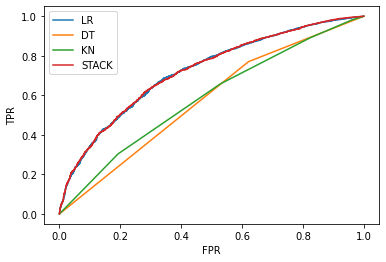

In [44]:
print("LR")
show_auc(y_test, y_pred_proba_lr, 'LR')
print("DT")
show_auc(y_test, y_pred_proba_dt, 'DT')
print("KN")
show_auc(y_test, y_pred_proba_kn, 'KN')
print("STACK")
show_auc(y_test, y_pred_proba, 'STACK')
plt.legend()
plt.show()

In [45]:
classifier.final_estimator_

LogisticRegression()

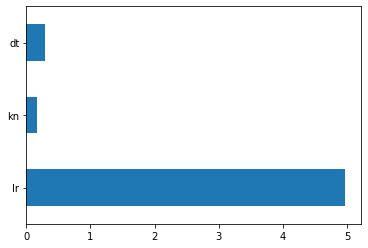

In [46]:
pd.Series(classifier.final_estimator_.coef_.flatten(), index=classifier.named_estimators_.keys()).plot(kind='barh')